In [24]:
!hostname

r004.ib.bridges2.psc.edu


In [2]:
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Tuple, Optional
from itertools import product
import os

import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
import pandas as pd

from nilearn.image import resample_img, resample_to_img

import plot_utils as ut

In [3]:
from importlib import reload
reload(ut)

<module 'plot_utils' from '/ocean/projects/med220004p/clane2/RBC/experiments/distortion_correction_evaluation/scripts/plot_utils.py'>

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

In [6]:
MNI152_2009c_AFFINE = np.array(
    [[   2.,    0.,    0.,  -96.],
    [   0.,    2.,    0., -132.],
    [   0.,    0.,    2.,  -78.],
    [   0.,    0.,    0.,    1.]]
)

MNI152_2009c_SHAPE = (97, 116, 98)

In [7]:
def corr_ratio(x: np.ndarray, y: np.ndarray, bins: int = 256) -> float:
    """
    Flirt correlation ratio cost function between `x` and `y`. Measures the variance
    in `y` over each iso-set of `x`.

    See [Jenkinson, NeuroImage 2002](https://doi.org/10.1006/nimg.2002.1132),
    Table 1 for the definition.
    """
    assert x.shape == y.shape, "x and y expected to have same shape"

    _, edges = np.histogram(x, bins=bins)
    count, cost = 0, 0.0
    for ii in range(bins):
        left, right = edges[ii: ii + 2]
        mask = (x >= left) & (x < right)
        iso_count = mask.sum()
        if iso_count > 0:
            y_iso_var = np.var(y[mask])
            cost = cost + iso_count * y_iso_var
            count = count + iso_count
    cost = cost / (np.var(y) * count)
    return cost

In [8]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation between two arrays.
    """
    assert x.shape == y.shape, "x and y expected to have same shape"
    x = x.flatten()
    y = y.flatten()
    c = np.sum(x * y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return c

In [9]:
def dice(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation between two masks
    """
    assert x.shape == y.shape, "x and y expected to have same shape"
    x = x > 0
    y = y > 0
    d = 2 * np.sum(x * y) / (x.sum() + y.sum())
    return d

In [10]:
def match_pattern(pattern: str) -> str:
    matches = glob(pattern)
    return None if len(matches) == 0 else matches[0]

In [11]:
def load_images_fmriprep(sesdir: str, apply_mask: bool = True, load_fdata: bool = True):
    images = {}
    images["t1w"] = match_pattern(f"{sesdir}/anat/*_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz")
    images["t1w_brain_mask"] = match_pattern(f"{sesdir}/anat/*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")
    images["boldref"] = match_pattern(f"{sesdir}/func/*_space-MNI152NLin2009cAsym_boldref.nii.gz")
    images["boldref_brain_mask"] = match_pattern(f"{sesdir}/func/*_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz")

    for k, path in images.items():
        images[k] = nib.load(path)
    
    for k in ["t1w", "t1w_brain_mask"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_img(
            images[k],
            target_affine=MNI152_2009c_AFFINE,
            target_shape=MNI152_2009c_SHAPE,
            interpolation=interpolation
        )

    for k in ["boldref", "boldref_brain_mask"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_to_img(images[k], images["t1w"], interpolation=interpolation)

    if apply_mask: 
        for k in ["t1w", "boldref"]:
            images[k] = nib.Nifti1Image(
                images[k].get_fdata() * (images[f"{k}_brain_mask"].get_fdata() > 0),
                affine=images[k].affine,
            )
    
    if load_fdata:
        for k in images:
            images[k] = images[k].get_fdata()
    
    return images

In [12]:
def load_images_cpac(sesdir: str, apply_mask: bool = True, load_fdata: bool = True):
    images = {}
    images["t1w"] = match_pattern(f"{sesdir}/anat/*_space-template_desc-preproc_T1w.nii.gz")
    images["boldref"] = match_pattern(f"{sesdir}/func/*_space-template_sbref.nii.gz")
    images["boldref_brain_mask"] = match_pattern(f"{sesdir}/func/*_space-template_desc-bold_mask.nii.gz")

    for k, path in images.items():
        images[k] = nib.load(path)
    
    for k in ["t1w"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_img(
            images[k],
            target_affine=MNI152_2009c_AFFINE,
            target_shape=MNI152_2009c_SHAPE,
            interpolation=interpolation
        )

    for k in ["boldref", "boldref_brain_mask"]:
        interpolation = "nearest" if "mask" in k else "continuous"
        images[k] = resample_to_img(images[k], images["t1w"], interpolation=interpolation)

    if apply_mask: 
        for k in ["boldref"]:
            images[k] = nib.Nifti1Image(
                images[k].get_fdata() * (images[f"{k}_brain_mask"].get_fdata() > 0),
                affine=images[k].affine,
            )
    
    if load_fdata:
        for k in images:
            images[k] = images[k].get_fdata()
    return images

In [13]:
subs = pd.read_csv("../etc/select_subs.csv")
subs.head()

,dataset,subject,session,sub_ses,fmap,task
0,NKI,A00031893,BAS1,sub-A00031893_ses-BAS1,none,task-rest_acq-1400
1,NKI,A00035377,BAS1,sub-A00035377_ses-BAS1,none,task-rest_acq-1400
2,NKI,A00035827,BAS2,sub-A00035827_ses-BAS2,none,task-rest_acq-1400
3,NKI,A00040815,BAS1,sub-A00040815_ses-BAS1,none,task-rest_acq-1400
4,NKI,A00052182,FLU2,sub-A00052182_ses-FLU2,none,task-rest_acq-1400


In [ ]:
def evaluate(sub: str, ses: str, fmap: str, pipeline: str):
    metrics = {"subject": sub, "session": ses, "fmap": fmap, "pipeline": pipeline}
    assert pipeline in {"fmriprep", "cpac"}
    if pipeline == "fmriprep":
        dc_images = load_images_fmriprep(
            f"../output/fmriprep_dc/sub-{sub}/ses-{ses}"
        )
        nodc_images = load_images_fmriprep(
            f"../output/fmriprep_nodc/sub-{sub}/ses-{ses}"
        )
    else:
        dc_images = load_images_cpac(
            f"../output/cpac/output/pipeline_rbc_distcorr_eval_dc/sub-{sub}_ses-{ses}"
        )
        nodc_images = load_images_cpac(
            f"../output/cpac/output/pipeline_rbc_distcorr_eval_nodc/sub-{sub}_ses-{ses}"
        )
    
    metrics["dc_to_nodc_boldref_corr"] = corr(
        dc_images["boldref"],
        nodc_images["boldref"],
    )
    metrics["dc_to_nodc_bold_mask_dice"] = dice(
        dc_images["boldref_brain_mask"],
        nodc_images["boldref_brain_mask"],
    )
    metrics["dc_boldref_t1w_corr_ratio"] = corr_ratio(
        dc_images["t1w"],
        dc_images["boldref"],
    )
    metrics["nodc_boldref_t1w_corr_ratio"] = corr_ratio(
        nodc_images["t1w"],
        nodc_images["boldref"],
    )
    return metrics

In [ ]:
def dummy_evaluate(sub: str, ses: str, fmap: str, pipeline: str):
    metrics = {"subject": sub, "session": ses, "fmap": fmap, "pipeline": pipeline}
    return metrics

In [ ]:
metrics = evaluate(sub="A00031893", ses="BAS1", fmap="none", pipeline="cpac")

In [ ]:
metrics

{'subject': 'A00031893',
 'session': 'BAS1',
 'fmap': 'none',
 'pipeline': 'cpac',
 'dc_to_nodc_boldref_corr': 1.0000000000000004,
 'dc_to_nodc_bold_mask_dice': 1.0,
 'dc_boldref_t1w_corr_ratio': 0.25202913410245187,
 'nodc_boldref_t1w_corr_ratio': 0.25202913410245187}

In [ ]:
pipelines = ["fmriprep", "cpac"]

results = []
for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
    for pipeline in pipelines:
        metrics = evaluate(sub, ses, fmap, pipeline)
        print("{subject} {session} {pipeline}".format(**metrics))
        results.append(metrics)

In [ ]:
pipelines = ["fmriprep", "cpac"]
futures, results = [], []

with ProcessPoolExecutor(max_workers=8) as pool:
    for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
        for pipeline in pipelines:
            # This works fine. Does nothing but put args into a dict
            # futures.append(pool.submit(dummy_evaluate, sub, ses, fmap, pipeline))
            
            # This doesn't work. Blocks with no tasks completing.
            # In `top` all python workers are suspended with 0% cpu.
            # `evaluate` involves reading nifti from disk with nibabel and some light data processing
            futures.append(pool.submit(evaluate, sub, ses, fmap, pipeline))
    
for future in as_completed(futures):
    metrics = future.result()
    print("{subject} {session} {pipeline}".format(**metrics))
    results.append(metrics)    

In [ ]:
results = pd.DataFrame.from_records(results)
results["dc_to_nodc_corr_ratio_delta"] = (
    results["dc_boldref_t1w_corr_ratio"] - results["nodc_boldref_t1w_corr_ratio"]
)

In [ ]:
# results.to_csv("../results/distcorr_metrics.csv", index=False)

In [ ]:
results = pd.read_csv("../results/distcorr_metrics.csv")

In [ ]:
results.head()

,subject,session,fmap,pipeline,dc_to_nodc_boldref_corr,dc_to_nodc_bold_mask_dice,dc_boldref_t1w_corr_ratio,nodc_boldref_t1w_corr_ratio,dc_to_nodc_corr_ratio_delta
0,A00031893,BAS1,none,fmriprep,0.999315,0.997329,0.125241,0.125382,-0.000141
1,A00031893,BAS1,none,cpac,1.000000,1.000000,0.252029,0.252029,0.000000
2,A00035377,BAS1,none,fmriprep,0.999356,0.997653,0.136376,0.136941,-0.000565
3,A00035377,BAS1,none,cpac,1.000000,1.000000,0.265085,0.265085,0.000000
4,A00035827,BAS2,none,fmriprep,0.999205,0.996475,0.163904,0.164760,-0.000856


In [ ]:
results["dc_to_nodc_corr_ratio_improvement"] = (
    1 - results["dc_boldref_t1w_corr_ratio"] / results["nodc_boldref_t1w_corr_ratio"]
)

In [145]:
def plot_scatter(df: pd.DataFrame, col: str, title: str = None):
    fmaps = ["none", "epi", "phasediff"]
    colors = ["r", "g", "b"]
    
    delta = 0.1
    for ii, fmap in enumerate(fmaps):
        x = df.loc[df["fmap"] == fmap, col].values
        plt.boxplot(x, positions=[(ii + 1 - delta)])
        plt.scatter(np.random.rand(len(x)) * 0.05 + delta + ii + 1, x, color=colors[ii], alpha=0.5)
    plt.xticks([1, 2, 3], fmaps, rotation=45)
    if title is not None:
        plt.title(title)

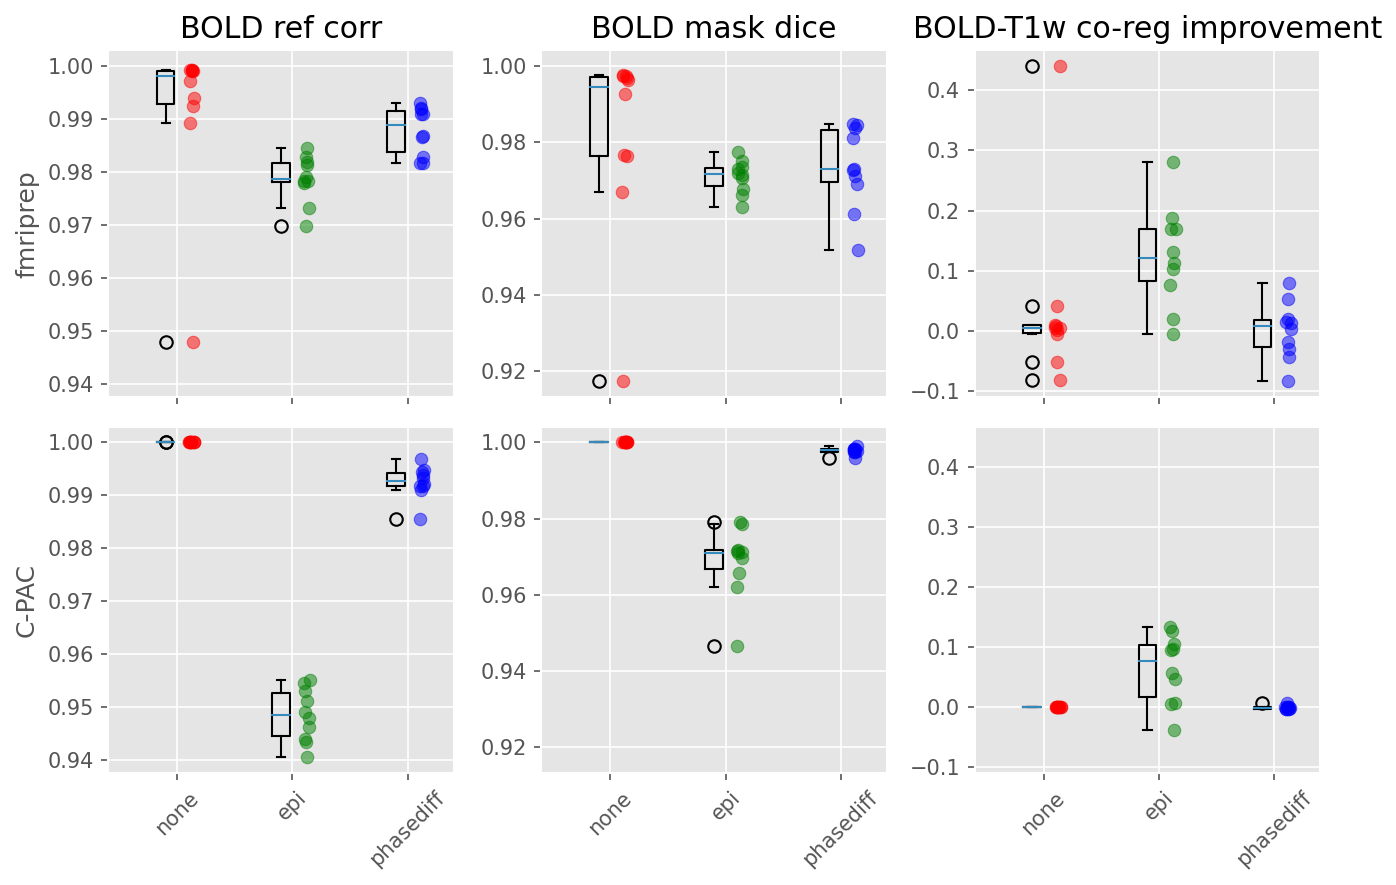

In [ ]:
cols = [
    ("dc_to_nodc_boldref_corr", "BOLD ref corr"),
    ("dc_to_nodc_bold_mask_dice", "BOLD mask dice"),
    # ("dc_to_nodc_corr_ratio_delta", "BOLD-T1w corr ratio delta"),
    ("dc_to_nodc_corr_ratio_improvement", "BOLD-T1w co-reg improvement"),
]
pipeline_names = {
    "fmriprep": "fmriprep",
    "cpac": "C-PAC",
}

plotw, ploth = 3.0, 3.0
nr, nc = 2, len(cols)
f, axs = plt.subplots(
    nr, nc, figsize=(nc * plotw, nr * ploth), sharex="col", sharey="col"
)

for ii, pipeline in enumerate(pipeline_names):
    df = results.loc[results["pipeline"] == pipeline, :]
    for jj in range(nc):
        plt.sca(axs[ii, jj])
        col, title = cols[jj]
        plot_scatter(df, col)
        if ii == 0:
            plt.title(title)
        if jj == 0:
            plt.ylabel(pipeline_names[pipeline])

plt.tight_layout()

In [ ]:
agg_results = results.groupby(["pipeline", "fmap"]).agg(
    {
        "dc_to_nodc_boldref_corr": "median",
        "dc_to_nodc_bold_mask_dice": "median",
        "dc_to_nodc_corr_ratio_improvement": "median",
    }
)
agg_results = agg_results.loc[(slice(None), "epi"), :]
agg_results

,,dc_to_nodc_boldref_corr,dc_to_nodc_bold_mask_dice,dc_to_nodc_corr_ratio_improvement
pipeline,fmap,,,
cpac,epi,0.948546,0.971078,0.075694
fmriprep,epi,0.978802,0.971765,0.121695


In [ ]:
def plot_overlay(images, z: int = 50):
    plt.imshow(images["boldref"][:, :, z], cmap="gray")
    left, right = np.quantile(images["t1w"][images["t1w"] != 0], [0.5, 0.95])
    mask = np.where((images["t1w"] >= left) & (images["t1w"] < right), 1.0, np.nan)
    plt.imshow(mask[:, :, z], cmap="Reds", vmin=0.0, alpha=0.5)

In [ ]:
def load_images(sub: str, ses: str, pipeline: str, load_fdata: bool=True):
    assert pipeline in {"fmriprep", "cpac"}
    if pipeline == "fmriprep":
        dc_images = load_images_fmriprep(
            f"../output/fmriprep_dc/sub-{sub}/ses-{ses}",
            load_fdata=load_fdata,
        )
        nodc_images = load_images_fmriprep(
            f"../output/fmriprep_nodc/sub-{sub}/ses-{ses}",
            load_fdata=load_fdata,
        )
    else:
        dc_images = load_images_cpac(
            f"../output/cpac/output/pipeline_rbc_distcorr_eval_dc/sub-{sub}_ses-{ses}",
            load_fdata=load_fdata,
        )
        nodc_images = load_images_cpac(
            f"../output/cpac/output/pipeline_rbc_distcorr_eval_nodc/sub-{sub}_ses-{ses}",
            load_fdata=load_fdata,
        )
    
    images = {"dc": dc_images, "nodc": nodc_images}
    return images

In [153]:
pipelines = ["fmriprep", "cpac"]
images = {}

for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
    for pipeline in pipelines:
        print(sub, ses, pipeline)
        images[(sub, ses, pipeline)] = load_images(sub, ses, pipeline)

A00031893 BAS1 fmriprep
A00031893 BAS1 cpac
A00035377 BAS1 fmriprep
A00035377 BAS1 cpac
A00035827 BAS2 fmriprep
A00035827 BAS2 cpac
A00040815 BAS1 fmriprep
A00040815 BAS1 cpac
A00052182 FLU2 fmriprep
A00052182 FLU2 cpac
A00065992 TRT fmriprep
A00065992 TRT cpac
A00066860 BAS1 fmriprep
A00066860 BAS1 cpac
A00066865 BAS1 fmriprep
A00066865 BAS1 cpac
A00074709 BAS1 fmriprep
A00074709 BAS1 cpac
A00081552 FLU1 fmriprep
A00081552 FLU1 cpac
NDARAA306NT2 HBNsiteRU fmriprep
NDARAA306NT2 HBNsiteRU cpac
NDARBE091BGD HBNsiteRU fmriprep
NDARBE091BGD HBNsiteRU cpac
NDARDZ266KET HBNsiteRU fmriprep
NDARDZ266KET HBNsiteRU cpac
NDARFG943GVZ HBNsiteCBIC fmriprep
NDARFG943GVZ HBNsiteCBIC cpac
NDARFM229HHA HBNsiteCBIC fmriprep
NDARFM229HHA HBNsiteCBIC cpac
NDARHW933UVJ HBNsiteCBIC fmriprep
NDARHW933UVJ HBNsiteCBIC cpac
NDARJL656RDA HBNsiteCBIC fmriprep
NDARJL656RDA HBNsiteCBIC cpac
NDARMB857WG7 HBNsiteCBIC fmriprep
NDARMB857WG7 HBNsiteCBIC cpac
NDARMG263JRX HBNsiteRU fmriprep
NDARMG263JRX HBNsiteRU cpac
ND

In [ ]:
def plot_pipeline_slices(
    sub: str,
    ses: str,
    axs: np.ndarray,
    dc: bool = True,
    ind: int = 45,
    dim: int = 0,
    ylabel: bool = True,
):
    assert axs.size == 3

    images_fmriprep = images[(sub, ses, "fmriprep")]["dc" if dc else "nodc"]
    images_cpac = images[(sub, ses, "cpac")]["dc" if dc else "nodc"]

    vmin, vmax = np.quantile(
        np.concatenate([
            images_fmriprep["boldref"].flatten(),
            images_cpac["boldref"].flatten(),
        ]),
        [0.02, 0.98],
    )
    vmin, vmax = None, None

    plt.sca(axs[0])
    ut.plot_array_slice(
        images_fmriprep["boldref"],
        ind=ind,
        dim=dim,
        cmap="gray",
        vmin=vmin,
        vmax=vmax,
    )
    if ylabel:
        plt.ylabel("fmriprep ref")
    
    plt.sca(axs[1])
    ut.plot_array_slice(
        images_cpac["boldref"],
        ind=ind,
        dim=dim,
        cmap="gray",
        vmin=vmin,
        vmax=vmax,
    )
    if ylabel:
        plt.ylabel("C-PAC ref")
    
    plt.sca(axs[2])
    ut.plot_array_slice(
        images_fmriprep["boldref"],
        ind=ind,
        dim=dim,
        cmap="gray",
        vmin=vmin,
        vmax=vmax,
    )
    ut.plot_array_slice(
        images_fmriprep["boldref_brain_mask"],
        ind=ind,
        dim=dim,
        mask=True,
        cmap=ut.ListedColormap(["blue"]),
        vmin=0.0,
        alpha=0.5,
    )
    ut.plot_array_slice(
        images_cpac["boldref_brain_mask"],
        ind=ind,
        dim=dim,
        mask=True,
        cmap=ut.ListedColormap(["red"]),
        vmin=0.0,
        alpha=0.5,
    )
    if ylabel:
        plt.ylabel("Mask overlay")
    transform = axs[2].transAxes
    plt.text(
        0.04,
        0.96,
        "fmriprep",
        backgroundcolor="blue",
        color="w",
        fontsize=8,
        transform=transform,
        ha="left",
        va="top",
    )
    plt.text(
        0.96,
        0.96,
        "C-PAC",
        backgroundcolor="red",
        color="w",
        fontsize=8,
        transform=transform,
        ha="right",
        va="top",
    )
    return axs

In [154]:
def plot_group_pipeline_slices(
    fmap: str = "none", dc: bool = True, ind: int = 45, dim: int = 2, fname: Optional[str] = None,
):
    df = subs.loc[subs["fmap"] == fmap]

    nr, nc = 3, len(df)
    pw, ph = 2.0, 2.0
    f, axs = plt.subplots(nr, nc, figsize=(nc*pw, nr*ph))

    for ii, (sub, ses) in enumerate(zip(df["subject"], df["session"])):
        col_axs = axs[:, ii]
        plot_pipeline_slices(
            sub, ses, col_axs, ind=ind, dim=dim, dc=dc, ylabel=(ii == 0)
        )
        for ax in col_axs:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.sca(axs[0, ii])
        plt.title(sub)
    
    plt.tight_layout(pad=0.0)
    if fname is not None:
        plt.savefig(fname, bbox_inches="tight")

In [ ]:
for fmap, dc in product(["none", "phasediff", "epi"], [0, 1]):
    plot_group_pipeline_slices(
        fmap=fmap, dc=dc, fname=f"../figures/bold_ref_comparison_{fmap}_dc{dc}.png"
    )

In [ ]:
sub_images = load_images("A00031893", "BAS1", "cpac", load_fdata=False)

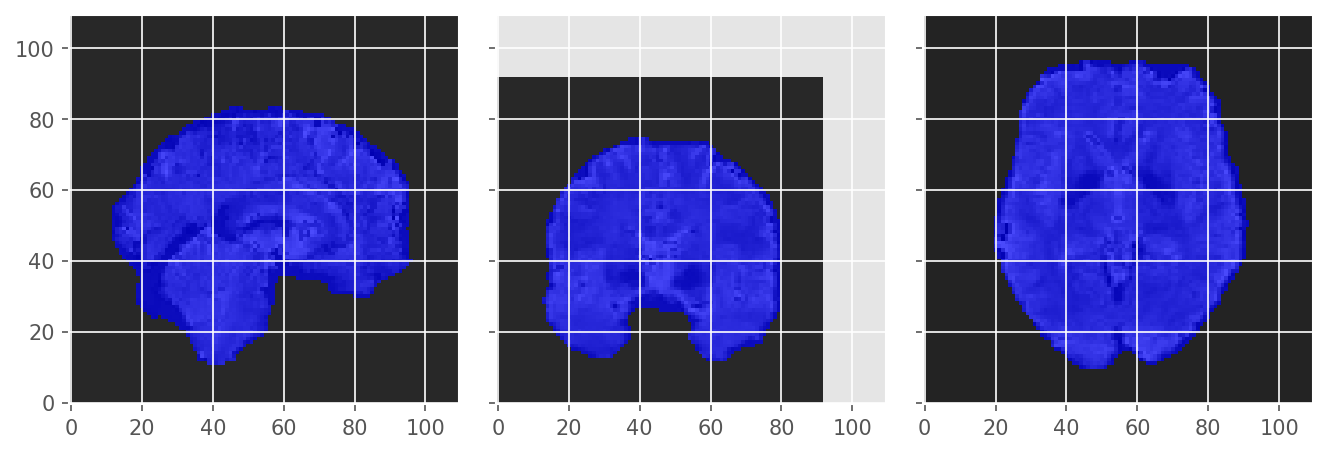

In [ ]:
f = ut.plot_masks(
    sub_images["nodc"]["boldref"],
    [sub_images["nodc"]["boldref_brain_mask"]],
    colors=["blue"],
)

In [156]:
def pipeline_comparison(sub: str, ses: str, fmap: str, dc: int):
    metrics = {"subject": sub, "session": ses, "fmap": fmap, "dc": dc}

    images_fmriprep = images[(sub, ses, "fmriprep")]["dc" if dc else "nodc"]
    images_cpac = images[(sub, ses, "cpac")]["dc" if dc else "nodc"]

    metrics["boldref_corr"] = corr(
        images_fmriprep["boldref"],
        images_cpac["boldref"],
    )
    metrics["bold_mask_dice"] = dice(
        images_fmriprep["boldref_brain_mask"],
        images_cpac["boldref_brain_mask"],
    )
    metrics["boldref_corr_ratio"] = corr_ratio(
        images_fmriprep["boldref"],
        images_cpac["boldref"],
    )
    return metrics

In [157]:
results = []
for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
    for dc in [0, 1]:
        metrics = pipeline_comparison(sub, ses, fmap, dc)
        print("{subject} {session} {dc}".format(**metrics))
        results.append(metrics)

A00031893 BAS1 0
A00031893 BAS1 1
A00035377 BAS1 0
A00035377 BAS1 1
A00035827 BAS2 0
A00035827 BAS2 1
A00040815 BAS1 0
A00040815 BAS1 1
A00052182 FLU2 0
A00052182 FLU2 1
A00065992 TRT 0
A00065992 TRT 1
A00066860 BAS1 0
A00066860 BAS1 1
A00066865 BAS1 0
A00066865 BAS1 1
A00074709 BAS1 0
A00074709 BAS1 1
A00081552 FLU1 0
A00081552 FLU1 1
NDARAA306NT2 HBNsiteRU 0
NDARAA306NT2 HBNsiteRU 1
NDARBE091BGD HBNsiteRU 0
NDARBE091BGD HBNsiteRU 1
NDARDZ266KET HBNsiteRU 0
NDARDZ266KET HBNsiteRU 1
NDARFG943GVZ HBNsiteCBIC 0
NDARFG943GVZ HBNsiteCBIC 1
NDARFM229HHA HBNsiteCBIC 0
NDARFM229HHA HBNsiteCBIC 1
NDARHW933UVJ HBNsiteCBIC 0
NDARHW933UVJ HBNsiteCBIC 1
NDARJL656RDA HBNsiteCBIC 0
NDARJL656RDA HBNsiteCBIC 1
NDARMB857WG7 HBNsiteCBIC 0
NDARMB857WG7 HBNsiteCBIC 1
NDARMG263JRX HBNsiteRU 0
NDARMG263JRX HBNsiteRU 1
NDARMV718DYL HBNsiteRU 0
NDARMV718DYL HBNsiteRU 1
1161831083 PNC1 0
1161831083 PNC1 1
1169616649 PNC1 0
1169616649 PNC1 1
1695950181 PNC1 0
1695950181 PNC1 1
2824066679 PNC1 0
2824066679 PNC1 

In [158]:
# results = pd.DataFrame.from_records(results)
# results.to_csv("../results/pipeline_comparison.csv", index=False)

In [159]:
results = pd.read_csv("../results/pipeline_comparison.csv")

In [160]:
results.head()

,subject,session,fmap,dc,boldref_corr,bold_mask_dice,boldref_corr_ratio
0,A00031893,BAS1,none,0,0.927149,0.977887,0.149080
1,A00031893,BAS1,none,1,0.927166,0.977945,0.148550
2,A00035377,BAS1,none,0,0.921943,0.979212,0.156538
3,A00035377,BAS1,none,1,0.921255,0.978905,0.158646
4,A00035827,BAS2,none,0,0.925756,0.976746,0.150085


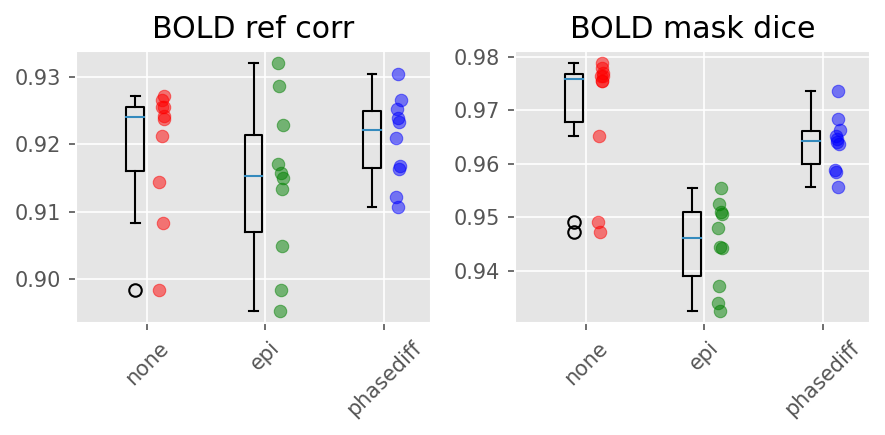

In [171]:
cols = [
    ("boldref_corr", "BOLD ref corr"),
    ("bold_mask_dice", "BOLD mask dice"),
    # ("boldref_corr_ratio", "BOLD ref corr ratio"),
]
dc = 1

plotw, ploth = 3.0, 3.0
nr, nc = 1, len(cols)
f, axs = plt.subplots(
    nr, nc, figsize=(nc * plotw, nr * ploth), sharex="col", sharey="col"
)

df = results.loc[results["dc"] == dc, :]
for jj in range(nc):
    plt.sca(axs[jj])
    col, title = cols[jj]
    plot_scatter(df, col)
    plt.title(title)

plt.tight_layout()
plt.savefig(f"../figures/pipeline_comparison_dc{dc}.png")

### Functional connectomes

In [15]:
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiLabelsMasker

In [16]:
SCHAEFER200_09c = nib.load("../etc/tpl-MNI152NLin2009cAsym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz")
SCHAEFER200_nlin6 = nib.load("../etc/tpl-MNI152NLin6Asym_res-02_atlas-Schaefer2018_desc-200Parcels7Networks_dseg.nii.gz")

In [17]:
print(SCHAEFER200_09c.shape)
print(SCHAEFER200_09c.affine)
print(SCHAEFER200_nlin6.shape)
print(SCHAEFER200_nlin6.affine)

(97, 115, 97)
[[   2.     0.    -0.   -96.5]
 [   0.     2.    -0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]
(91, 109, 91)
[[   2.    0.    0.  -90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]


In [18]:
# masker = NiftiLabelsMasker(labels_img=cc200)
# masker.fit(func)
# cc200_func_data = masker.transform(func)

In [23]:
def load_timeseries(sub: str, ses: str, pipeline: str, dc: bool):
    npy_path = f"../results/sub-{sub}_ses-{ses}_pipeline-{pipeline}_dc-{dc}.npy"
    if os.path.exists(npy_path):
        func_data = np.load(npy_path)
        return func_data, (sub, ses, pipeline, dc)

    assert pipeline in {"fmriprep", "cpac"}
    dc_str = "dc" if dc else "nodc"
    if pipeline == "fmriprep":
        func_path = match_pattern(
            f"../output/fmriprep_{dc_str}/sub-{sub}/ses-{ses}/func/"
            "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
        )
        atlas = SCHAEFER200_09c
    else:
        func_path = match_pattern(
            f"../output/cpac/output/pipeline_rbc_distcorr_eval_{dc_str}/sub-{sub}_ses-{ses}/func/"
            "*_space-template_desc-preproc_bold.nii.gz"
        )
        atlas = SCHAEFER200_nlin6
    func = nib.load(func_path)

    masker = NiftiLabelsMasker(labels_img=atlas)
    masker.fit(func)
    func_data = masker.transform(func)
    assert np.sum(np.isfinite(func_data)) == func_data.size
    np.save(npy_path, func_data)
    return func_data, (sub, ses, pipeline, dc)

In [20]:
sub = "A00031893" 
ses = "BAS1"

func_data, key = load_timeseries(sub, ses, "cpac", False) 

In [21]:
timeseries = {}

In [26]:
pipelines = ["fmriprep", "cpac"]
settings = [0, 1]

for sub, ses in zip(subs["subject"], subs["session"]):
    for pipeline, dc in product(pipelines, settings):
        key = sub, ses, pipeline, dc
        if key not in timeseries:
            print(*key)
            timeseries[key], _ = load_timeseries(*key)

In [27]:
len(timeseries)

120

In [30]:
corrcoefs = {}
for k, v in timeseries.items():
    corrcoefs[k] = np.corrcoef(v.T)

In [91]:
def plot_connectome(
    sub: str,
    ses: str,
    pipeline: str,
    dc: int,
    colorbar: bool = False,
    center: bool = True,
    vmin: float = -0.8,
    vmax: float = 0.8,
):
    mat = corrcoefs[(sub, ses, pipeline, dc)]
    if center:
        mat = mat - np.median(mat)
    plt.imshow(mat, cmap="seismic", interpolation="nearest", vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([])
    plt.yticks([])

In [ ]:
f, axs = plt.subplots(1, 2)

plt.sca(axs[0])
plot_connectome(sub, ses, "fmriprep", 0, colorbar=False)
plt.sca(axs[1])
plot_connectome(sub, ses, "cpac", 0, colorbar=False)

In [129]:
def plot_group_connectome(
    fmap="none",
    pipelines=["fmriprep", "cpac"],
    dcs=[1],
    nsubs=10,
    fname = None,
):
    settings = list(product(pipelines, dcs))

    plotw, ploth = 2.0, 2.0
    nr, nc = len(settings), nsubs
    f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

    df = subs.query(f"fmap == '{fmap}'")

    pipeline_names = {
        "fmriprep": "fmriprep",
        "cpac": "C-PAC",
    }
    dc_labels = ["DC: Off", "DC: On"]

    for ii, (pl, dc) in enumerate(settings):
        for jj in range(nsubs):
            row = df.iloc[jj]
            sub, ses = row["subject"], row["session"]
            plt.sca(axs[ii, jj])
            plot_connectome(sub, ses, pl, dc)
            if ii == 0:
                plt.title(sub)
            if jj == 0:
                plt.ylabel(f"{pipeline_names[pl]}, {dc_labels[dc]}")

    plt.tight_layout(pad=0.5, w_pad=0.0)
    if fname is not None:
        plt.savefig(fname, bbox_inches="tight")

In [ ]:
for fmap in ["none", "phasediff", "epi"]:
    for dc in [0, 1]:
        fname = f"../figures/schaefer_connectome_by_pipeline_fmap-{fmap}_dc-{dc}.png"
        plot_group_connectome(fmap=fmap, dcs=[dc], fname=fname)

In [137]:
from scipy.stats import spearmanr

In [141]:
results = []

rind, cind = np.triu_indices(200, 1)

for sub, ses, fmap in zip(subs["subject"], subs["session"], subs["fmap"]):
    for dc in [0, 1]:
        metrics = {"subject": sub, "session": ses, "fmap": fmap, "dc": dc}
        x1 = corrcoefs[(sub, ses, "fmriprep", dc)][rind, cind]
        x2 = corrcoefs[(sub, ses, "cpac", dc)][rind, cind]

        metrics["cross_pipeline_connectome_spearman"], _ = spearmanr(x1, x2)
        results.append(metrics)

In [142]:
results = pd.DataFrame(results)

In [143]:
results.head()

,subject,session,fmap,dc,cross_pipeline_connectome_spearman
0,A00031893,BAS1,none,0,0.921654
1,A00031893,BAS1,none,1,0.922892
2,A00035377,BAS1,none,0,0.963087
3,A00035377,BAS1,none,1,0.960520
4,A00035827,BAS2,none,0,0.961195


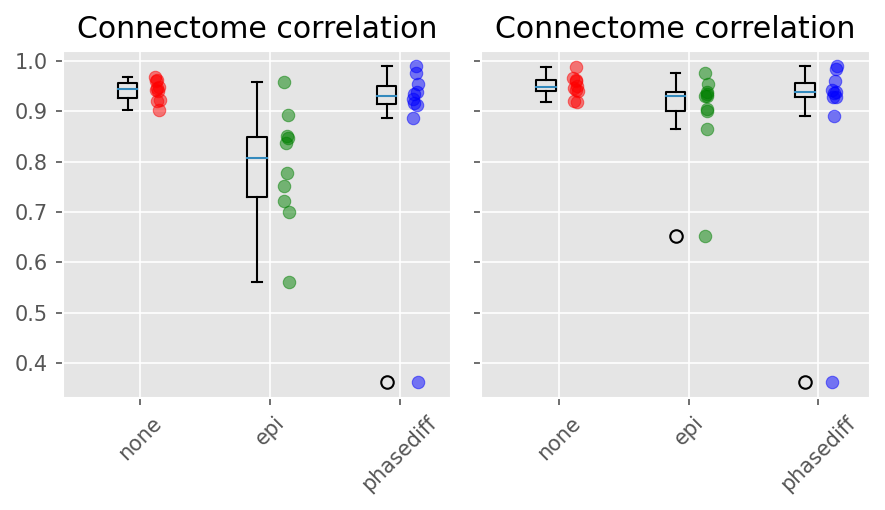

In [149]:

cols = [
    ("cross_pipeline_connectome_spearman", "Connectome correlation")
]

plotw, ploth = 3.0, 3.5
nr, nc = 1, 2
f, axs = plt.subplots(
    nr, nc, figsize=(nc * plotw, nr * ploth), sharex=True, sharey=True,
)

dcs = [1, 0]
dc_labels = ["DC: Off", "DC: On"]

for jj, dc in enumerate(dcs):
    df = results.loc[results["dc"] == dc, :]
    plt.sca(axs[jj])
    col, title = cols[0]
    plot_scatter(df, col)
    plt.title(title)

plt.tight_layout()

In [153]:
def IQR(x):
    q25, q75 = np.quantile(x, [0.25, 0.75])
    return q75 - q25

results.groupby(["fmap", "dc"]).agg(
    {"cross_pipeline_connectome_spearman": ["median", IQR]}
)

cross_pipeline_connectome_spearman          
                                         median       IQR
fmap      dc                                             
epi       0                            0.930771  0.035944
          1                            0.807843  0.120987
none      0                            0.947736  0.021210
          1                            0.944368  0.029747
phasediff 0                            0.937724  0.028560
          1                            0.929944  0.037159

In [155]:
results.sort_values("cross_pipeline_connectome_spearman").head()

,subject,session,fmap,dc,cross_pipeline_connectome_spearman
41,1161831083,PNC1,phasediff,1,0.361525
40,1161831083,PNC1,phasediff,0,0.362821
23,NDARBE091BGD,HBNsiteRU,epi,1,0.561513
22,NDARBE091BGD,HBNsiteRU,epi,0,0.652528
31,NDARHW933UVJ,HBNsiteCBIC,epi,1,0.699540
